In [84]:
import os
import io 

import json
import pandas as pd

from geomagio.iaga2002 import IAGA2002Factory
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
### Loading data in bgs json format.

had_json_fp = "HAD_json"
esk_json_fp = "ESK_json"

def load_bgs_json(folder):
    for f in os.listdir(folder):
        if f.endswith(".json"):
            with open(os.path.join(folder, f)) as dat_file:
                mag_json = json.load(dat_file)
                try:
                    mag_dat.append(pd.DataFrame(mag_json["timeSeries"]["dataPoints"]))
                except NameError:
                    mag_dat = pd.DataFrame(mag_json["timeSeries"]["dataPoints"])
    
    mag_dat["time"] = pd.to_datetime(mag_dat["time"])
    return mag_dat

test_df = load_bgs_json(had_json_fp)

In [23]:
test_df.tail()

,F,X,Y,Z,time
43195,48470.00,19669.00,-970.00,44289.00,2012-04-30 23:55:00
43196,48470.00,19669.00,-970.00,44289.00,2012-04-30 23:56:00
43197,48470.00,19669.00,-970.00,44289.00,2012-04-30 23:57:00
43198,48470.00,19669.00,-970.00,44289.00,2012-04-30 23:58:00
43199,48470.00,19669.00,-970.00,44289.00,2012-04-30 23:59:00


In [86]:
### Loading data in the IAGA 2002 format.

def iaga2002_to_df(file):
    row = next(file)
    while row:
        vals = row.split()
        if vals[0] == "DATE":
            vals.remove('|')
            vals.remove("DOY")
            vals.remove("DATE")
            vals[0] = vals[0].lower()
            vals[1:] = (label[-1] for label in vals[1:])
            cols = vals
            break
        row = next(file)
    
    all_rows = []
    for i, row in enumerate(file):
        vals = row.split()
        vals[0] = vals[0] + " " + vals.pop(1)
        del vals[1]
        all_rows.append(vals)
    
    mag_dat = pd.DataFrame(all_rows, columns = cols)
    mag_dat["time"] = pd.to_datetime(mag_dat["time"])
    mag_dat[cols[1:]] = mag_dat[cols[1:]].astype("float32")
    mag_dat.set_index("time", inplace=True)
    return mag_dat
    
def load_intermagnet_iaga_min(folder):
    for f in os.listdir(folder):
        if f.endswith(".min"):
            with open(os.path.join(folder, f)) as dat_file:
                try:
                    mag_dat = mag_dat.append(iaga2002_to_df(dat_file))
                except NameError:
                    mag_dat = iaga2002_to_df(dat_file)
    
    return mag_dat

mag_dat = load_intermagnet_iaga_min("HAD_iaga")
mag_dat.head()

,H,D,Z,F
time,,,,
2017-08-28 23:55:00,19780.400391,-113.190002,44389.898438,48597.601562
2017-08-28 23:56:00,19780.199219,-113.190002,44389.800781,48597.398438
2017-08-28 23:57:00,19780.500000,-113.190002,44389.800781,48597.500000
2017-08-28 23:58:00,19780.300781,-113.190002,44389.699219,48597.398438
2017-08-28 23:59:00,19780.400391,-113.199997,44389.601562,48597.300781


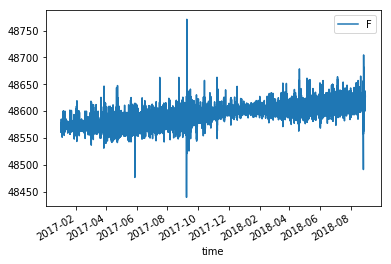

In [87]:
mag_dat.plot(y="F")